In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import lb
import lb.hpi_parse_viz as hpi_parse_viz
import lb.prior
import matplotlib.pyplot as plt
import figs
%load_ext autoreload
%autoreload 2


In [2]:
D = lb.exp.Data.load('0.4').qualified()


Large difference 83ms between duration 26914ms and end-start difference 26831ms for pid=md5:8c43bec3733bb9976c197bff02dbf4e2 trial=3
Large difference 155ms between duration 6858ms and end-start difference 6703ms for pid=md5:fce1be10fd7e4f749e9b5f731056d7f3 trial=4
Modal row count 34. # matching 193 / 235
# with no programming 171 / 235
# valid workers 171 / 235


In [3]:
# This doesn't matter too much
ctx_kw = dict(size=(400, 400))


# Introductory example

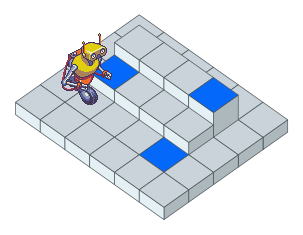

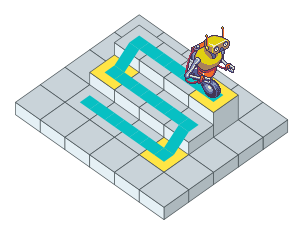

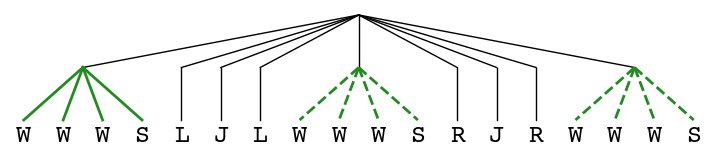

In [4]:
mdp_name = ('maps', 8)
program = lb.tools.mkprog('1EBE1DBD1', 'CCCA')

mdp = lb.exp.mdp_from_name(mdp_name)

for name, p in [
    ('intro-task.pdf', None),
    ('intro-trace.pdf', program),
]:
    lb.render.render(
        mdp, program=p, display=True, ctx_kw=ctx_kw,
        save_fn=figs.path(name))
    plt.show()

hpi_parse_viz.Compat.plot_program(program, show_reuse=True)
figs.save(f'intro-program.pdf')
plt.show()


# Render tasks

In [5]:
trs = D.participants[0].task_rows()
assert len(trs) == 10, 'Picking an arbitrary participants, but they must have all rows'

for idx, tr in enumerate(trs):
    assert figs.mdp_names[idx] == tr.mdp_name
    print(tr.mdp_name)
    lb.render.render(
        tr.mdp, display=False, ctx_kw=ctx_kw,
        save_fn=figs.path(f'exp-task{idx}.pdf'))


('cgcMaps', 14)
('cgcMaps', 3)
('maps', 8)
('cgcMaps', 15)
('maps', 7)
('cgcMaps', 8)
('cgcMaps', 9)
('cgcMaps', 12)
('cgcMaps', 11)
('maps', 6)


# Participant data samples

In [6]:
samples = {
    ('maps', 8): [
        lb.tools.mkprog('1EBE1DBD1', 'CCCA'),
        lb.tools.mkprog('1CCC1DBBA', 'EBAD'),
    ],
    ('cgcMaps', 15): [
        lb.tools.mkprog('E1DBD1EBE1', 'CACCA'),
        lb.tools.mkprog('1DBD2EB1', 'E2', 'CACCA'),
        lb.tools.mkprog('1DBDCACCAEB1', 'ECACCA'),
    ],
    ('cgcMaps', 12): [
        lb.tools.mkprog('L11RJL1R1R1JR1', 'JS'),
        lb.tools.mkprog('L11RJL122J2', 'JS', 'R1'),
    ],
}


In [7]:
for mdp_name, progs in samples.items():
    bs = lb.fitting.BehaviorSummary(lb.exp.mdp_from_name(mdp_name), D.programs_by_count()[mdp_name])
    print(f'{mdp_name=}')
    print('count for most common trace', max(bs.trace_counts.values()))
    for pi, prog in enumerate(progs):
        t = lb.program_analysis.FlattenProgram.flatten(prog)
        print(f'program {pi} trace count {bs.trace_counts[t]}')
    print()


mdp_name=('maps', 8)
count for most common trace 76
program 0 trace count 76
program 1 trace count 2

mdp_name=('cgcMaps', 15)
count for most common trace 109
program 0 trace count 109
program 1 trace count 109
program 2 trace count 109

mdp_name=('cgcMaps', 12)
count for most common trace 84
program 0 trace count 84
program 1 trace count 84



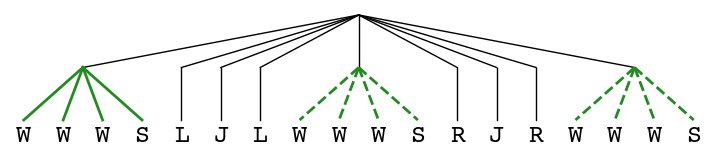

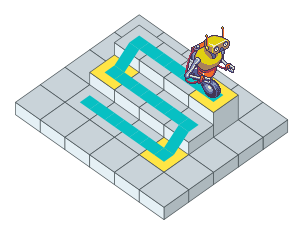

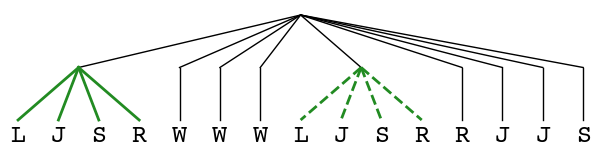

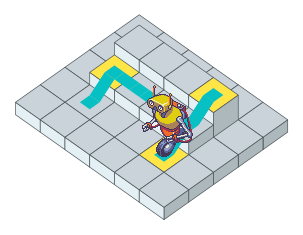

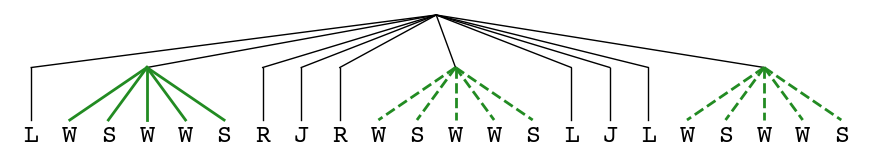

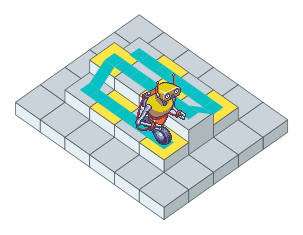

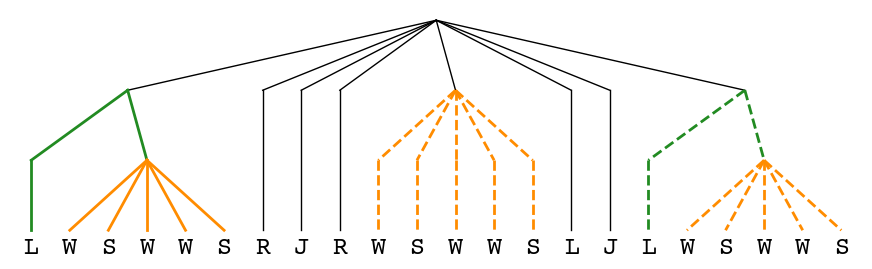

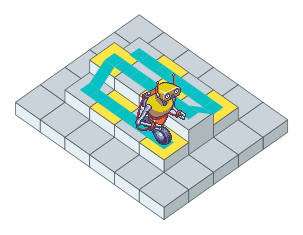

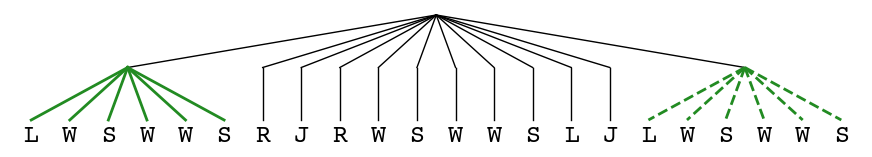

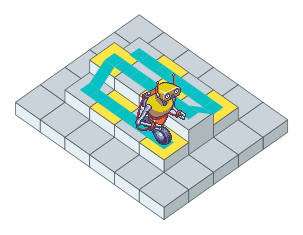

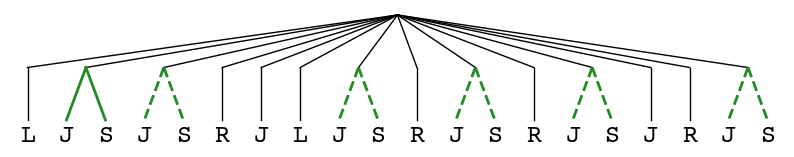

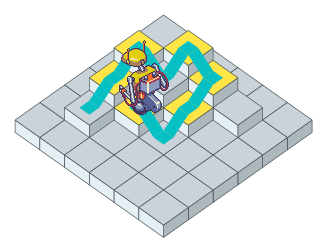

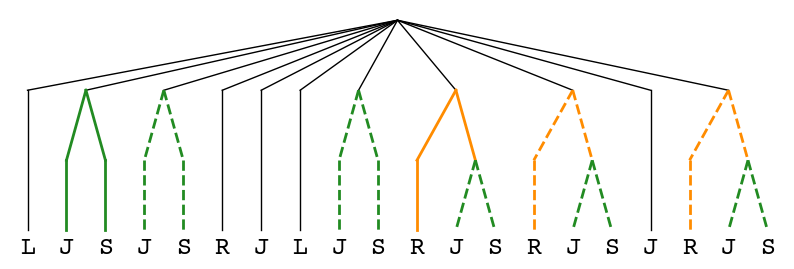

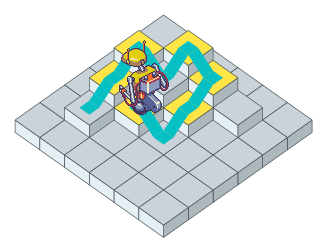

\begin{tabular}{lll}
\toprule
{} &                                                                                       0 &                                                                                       1 \\
\midrule
\midrule
\makecell{trace}                            &  \makecell{\includegraphics[scale=.35]{figures/results/qual-samples-maps-8-trace0.pdf}} &  \makecell{\includegraphics[scale=.35]{figures/results/qual-samples-maps-8-trace1.pdf}} \\
\midrule
\makecell{program}                          &   \makecell{\includegraphics[scale=0.2]{figures/results/qual-samples-maps-8-prog0.pdf}} &   \makecell{\includegraphics[scale=0.2]{figures/results/qual-samples-maps-8-prog1.pdf}} \\
\midrule
\makecell{participant count}                &                                                                                      59 &                                                                                       1 \\
\midrule
\makecell{step count}                       &             

In [8]:
def prior(p):
    p_end = 1/10
    p_normal = 1/2
    return lb.prior.pyp_process_prior(
        p, a=0, b=1,
        p_normal=p_normal,
        p_end=p_end,
        p_subprocess_end=p_end,
    )

allrows = []

cts = D.programs_by_count()
for mdp_name, programs in samples.items():
    rows = []
    mdp = lb.exp.mdp_from_name(mdp_name)
    bs = lb.fitting.BehaviorSummary(mdp, cts[mdp_name])
    mdp_name_out = f'{mdp_name[0]}-{mdp_name[1]}'
    for pi, program in enumerate(programs):
        fn = f'qual-samples-{mdp_name_out}-prog{pi}.pdf'
        fn_trace = f'qual-samples-{mdp_name_out}-trace{pi}.pdf'
        sc = (
            bs.program_step_counters[program]
            if program in bs.program_step_counters else
            lb.program_analysis.ProgramStepCounter.count(mdp, program)
        )
        assert (
            sc.step_noop == 0 and
            sc.step_post == 0 and
            sc.step_post_noop == 0
        ), 'sanity check, programs should have only have step costs, no others'
        config = {
            2: {
                'participant count': 'participant count',
                'program length': 'program length',
                'prog_scale': .2,
            },
            3: {
                'participant count': 'part. count',
                'program length': 'prog. length',
                'prog_scale': .14,
            },
        }[len(programs)]
        row = {
            'trace': r'\makecell{\includegraphics[scale=.35]{figures/results/'+fn_trace+'}}',
            'program': r'\makecell{\includegraphics[scale=' + str(config["prog_scale"]) + r']{figures/results/'+fn+'}}',
            config['participant count']: bs.program_counts[program],
            'step count': sc.step,
            config['program length']: lb.hier_len(program),
            r'grammar induction \\ prior (log)': '{:.2f}'.format(prior(program)),
        }
        row = {
            # r'\makecell{' + r' \\ '.join(k.split()) + '}': v
            r'\makecell{' + k + '}': v
            for idx, (k, v) in enumerate(row.items())}
        rows.append(row)

        hpi_parse_viz.Compat.plot_program(program, show_reuse=True)
        figs.save(fn)
        plt.show()

        lb.render.render(
            mdp, program=program, display=True, ctx_kw=ctx_kw,
            save_fn=figs.path(fn_trace))
        plt.show()

    # Copy/pasted pd_to_latex to work for this transposed table.
    with pd.option_context('display.max_colwidth', 999999):
        allrows.append(
            pd.DataFrame(rows).T.to_latex(escape=False).replace('\\\\\n', '\\\\\n\\midrule\n')
        )

for row in allrows:
    print(row)
